<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting the Density Estimator

In [1]:
## todo add forked repo as origin or upstream
## check paths
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#! pip install --user -e /global/u2/v/vboehm/codes/SIG_GIS/

In [3]:
import sys

In [4]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')

In [5]:
from sig_gis import *

In [6]:
from sig_gis.GIS import *

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label+'_minz01_maxz036_minSN50'+'_8_fully_connected_large'

seed            = 8720

latent_dim      = 8
network_type    = 'fully_connected'

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [9]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s.npy'%label_2), allow_pickle=True)
decoded_train, decoded_valid, decoded_test = np.load(os.path.join(root_decoded,'decoded_%s.npy'%label_2), allow_pickle=True)

In [10]:
seed = 8365

In [11]:
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')

In [12]:
encoded_train = torch.tensor(encoded_train).to(device)
encoded_valid = torch.tensor(encoded_valid).to(device)

In [14]:
try:
    model =  torch.load('GIS_%s_seed%d'%(label_2,seed))
except:
    model = train_GIS(encoded_train, data_validate=encoded_valid, alpha=torch.tensor((0.8,0.8)).to(device), MSWD_max_iter=200)

Fit A: Time: 40.09847664833069 Wasserstein Distance: [2.5560460090637207, 1.1125081777572632, 0.9680078625679016, 0.9579035639762878, 0.926297128200531, 0.9239162802696228, 0.8612687587738037, 0.7242969274520874]
Fit spline Time: 1.015042781829834
logp: -11.334663391113281 -11.188007354736328 time: 41.325148582458496 iteration: 1 best: 1
Fit A: Time: 39.850390911102295 Wasserstein Distance: [1.9721561670303345, 1.125882863998413, 0.8900233507156372, 0.8634980320930481, 0.7448785901069641, 0.6952390670776367, 0.6730931997299194, 0.6457359790802002]
Fit spline Time: 0.9759681224822998
logp: -7.509592056274414 -7.4037041664123535 time: 41.028512477874756 iteration: 2 best: 2
Fit A: Time: 39.88984799385071 Wasserstein Distance: [1.6345129013061523, 0.8211833238601685, 0.7414424419403076, 0.7271681427955627, 0.61429363489151, 0.5647838711738586, 0.5517948269844055, 0.5356622338294983]
Fit spline Time: 0.9784457683563232
logp: -5.049161434173584 -4.96901798248291 time: 41.07396483421326 iter

KeyboardInterrupt: 

In [ ]:
torch.save(model, os.path.join(root_models,'GIS_%s'%label_2)

In [ ]:
#torch.save(model, 'GIS_%s_seed%d'%(label_2,seed))
model.evaluate_density(encoded_valid[0:100]).cpu()

In [ ]:
label_          = label+'_minz005_maxz036_minSN50'


res_fluxes, res_masks, res_inv_vars = np.load(os.path.join(root_prepped,'prepped_data_spectra_%s.npy'%label_),allow_pickle=True)
redshifts, SNs, ras, decs, category, sublabel = np.load(os.path.join(root_prepped,'prepped_data_prop_%s.npy'%label_),allow_pickle=True)


mean=np.mean(res_fluxes)
print(mean)

DATASET_SIZE = len(res_fluxes)
train_size   = int(0.6 * DATASET_SIZE)
test_size    = int(0.2 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)

train_data   = np.expand_dims(res_fluxes[:train_size],-1)/mean
valid_data   = np.expand_dims(res_fluxes[train_size:train_size+valid_size],-1)/mean
test_data    = np.expand_dims(res_fluxes[-test_size::],-1)/mean

train_mask   = np.expand_dims(res_masks[:train_size],-1)
valid_mask   = np.expand_dims(res_masks[train_size:train_size+valid_size],-1)
test_mask    = np.expand_dims(res_masks[-test_size::],-1)

train_noise  = np.expand_dims(res_inv_vars[:train_size],-1)*mean**2
valid_noise  = np.expand_dims(res_inv_vars[train_size:train_size+valid_size],-1)*mean**2
test_noise   = np.expand_dims(res_inv_vars[-test_size::],-1)*mean**2

train_params = np.asarray(redshifts, dtype=np.float32)[:train_size]
valid_params = np.asarray(redshifts, dtype=np.float32)[train_size:train_size+valid_size]
test_params = np.asarray(redshifts, dtype=np.float32)[-test_size::]

train_ras = np.asarray(ras, dtype=np.float32)[:train_size]
valid_ras = np.asarray(ras, dtype=np.float32)[train_size:train_size+valid_size]
test_ras = np.asarray(ras, dtype=np.float32)[-test_size::]

train_decs = np.asarray(decs, dtype=np.float32)[:train_size]
valid_decs = np.asarray(decs, dtype=np.float32)[train_size:train_size+valid_size]
test_decs = np.asarray(decs, dtype=np.float32)[-test_size::]

train_cat = category[:train_size]
valid_cat = category[train_size:train_size+valid_size]
test_cat = category[-test_size::]

train_labels = sublabel[:train_size]
valid_labels = sublabel[train_size:train_size+valid_size]
test_labels = sublabel[-test_size::]

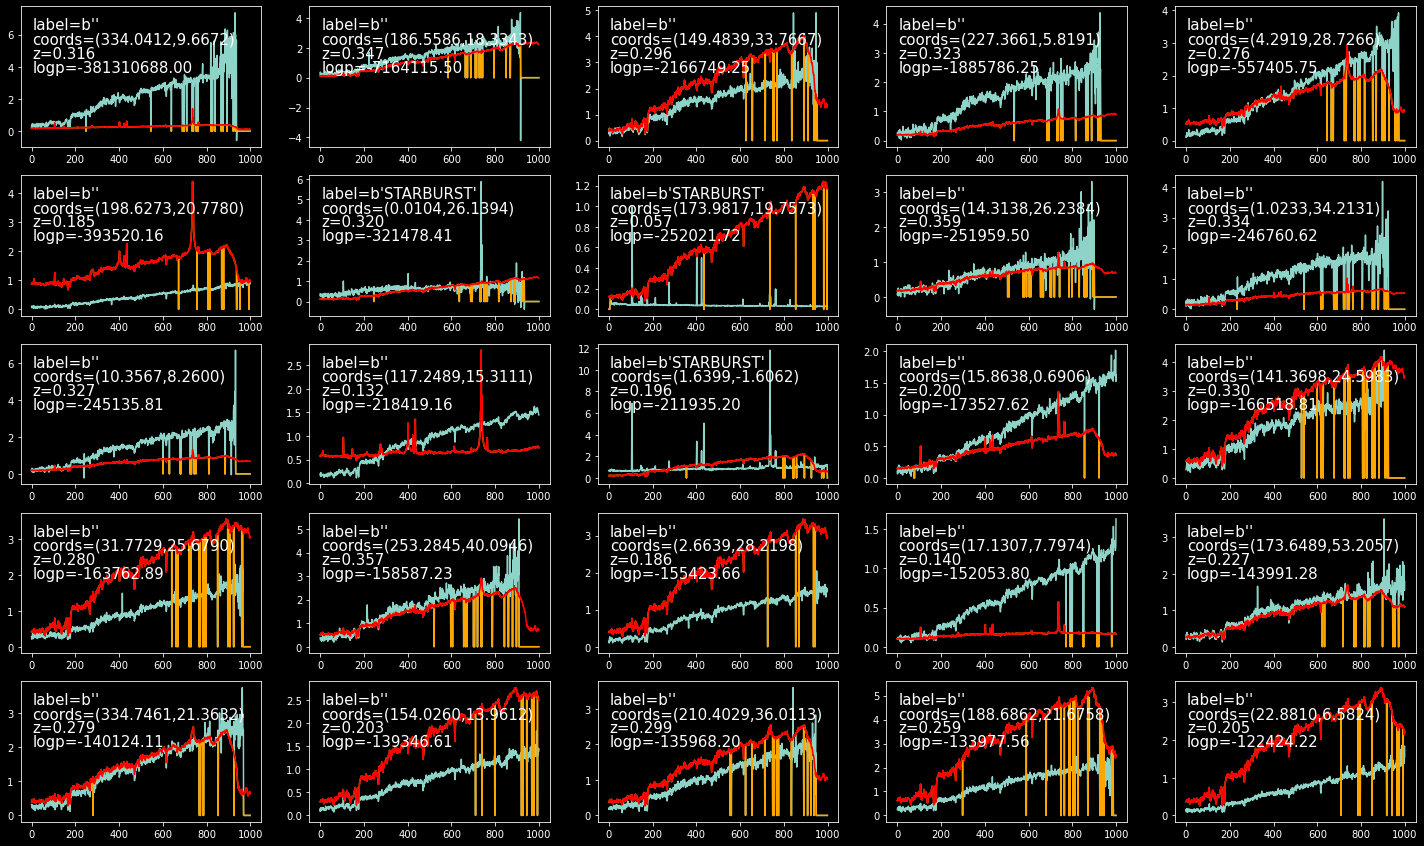

In [23]:

logps_valid = model.evaluate_density(encoded_valid).cpu()

indices = np.argsort(logps_valid)


style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices[0:25]):
                ax[nn].plot(new_wl,np.squeeze(valid_data)[ii]*np.squeeze(valid_mask)[ii], )
                ax[nn].plot(new_wl,np.squeeze(decoded_valid)[ii]*np.squeeze(valid_mask)[ii], color='orange')
                ax[nn].plot(new_wl,np.squeeze(decoded_valid)[ii], color='red')
                ax[nn].text(0.05, 0.92, r'label=%s'%valid_labels[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'coords=(%.4f,%.4f)'%(valid_ras[ii],valid_decs[ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.72, r'z=%.3f'%valid_params[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.62, r'logp=%.2f'%logps_valid[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

KeyboardInterrupt: 

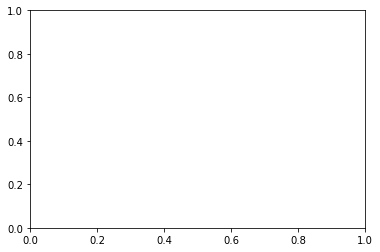

In [24]:
_ = plt.hist(logps_valid[:1000], bins=100)
#plt.show()

In [ ]:
# cluster by recon error

In [ ]:
logps_train = model.evaluate_density(encoded_train).cpu()

indices = np.argsort(logps_train)

style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices[0:25]):
                ax[nn].plot(new_wl[:-1], np.squeeze(train_data)[ii]*np.squeeze(train_mask)[ii], )
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_train)[ii]*np.squeeze(train_mask)[ii], color='orange')
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_train)[ii], color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%train_params[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'logp=%.2f'%logps_train[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

In [ ]:
_ = plt.hist(logps_train, bins=100, density=True, log=True, cumulative=True)
